# Moving Average Strategy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from pandas_datareader import data as web
import talib as ta
import yfinance as yf
yf.pdr_override()

## 1.Parameter Assumption

In [3]:
symbol = 'HOME'
start_time = datetime(2020,1,1)
end_time = datetime.now()

EMA_st = 10
EMA_lt = 30
SD = 5

benchmark = '^GSPC'

## 2. Data Preparation (yahoo finance)

In [4]:
data=web.get_data_yahoo(symbol,start=start_time,end=end_time)
data.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)
data.rename(columns={'Close':'Price'},inplace=True)
data['Return']=np.log(data['Price']/data['Price'].shift(1))

# Exponential Moving Average
data['EMA_st']=ta.EMA(data['Price'], timeperiod = EMA_st)
data['EMA_lt']=ta.EMA(data['Price'], timeperiod = EMA_lt)

# Simple Moving Average
# data['EMA_st']=ta.SMA(data['Price'], timeperiod = EMA_st)
# data['EMA_lt']=ta.SMA(data['Price'], timeperiod = EMA_lt)

benchmark = web.get_data_yahoo(benchmark, start=start_time, end=end_time)
benchmark['Bench_Return']=np.log(benchmark['Close']/benchmark['Close'].shift(1))

data = pd.concat([data, benchmark['Bench_Return']], axis=1, join='inner')

data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Price,Return,EMA_st,EMA_lt,Bench_Return
Date,,,,,
2020-12-29,15.150000,-0.018313,15.791443,16.330945,-0.002230
2020-12-30,15.310000,0.010506,15.703908,16.265078,0.001341
2020-12-31,15.460000,0.009750,15.659561,16.213137,0.006418
2021-01-04,15.770000,0.019853,15.679641,16.184548,-0.014865
2021-01-05,16.319901,0.034276,15.796052,16.193280,0.004984


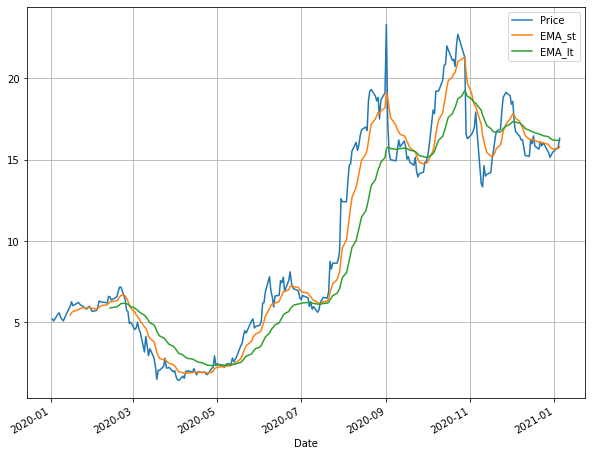

In [5]:
data[['Price','EMA_st','EMA_lt']].plot(grid=True,figsize=(10,8))

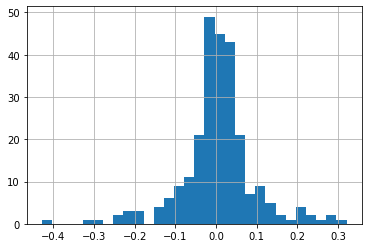

In [6]:
data['Return'].hist(bins=30)

## 3.Model Development and Optimization

In [7]:
data.dropna(inplace=True)
data['Position']=np.where(data['EMA_st']>data['EMA_lt'],1,-1)
data['Strategy']=data['Position'].shift(1)*data['Return']
print(data['Position'].value_counts())

data['st-lt']=data['EMA_st']-data['EMA_lt']
data['Regime']=np.where(data['st-lt']>SD*data['Return'].std(),1,0)
data['Regime']=np.where(data['st-lt']<-SD*data['Return'].std(),-1,data['Regime'])
data['Optimized_Strategy']=data['Regime'].shift(1)*data['Return']
print(data['Regime'].value_counts())

 1    131
-1     95
Name: Position, dtype: int64
 1    89
 0    83
-1    54
Name: Regime, dtype: int64


Text(0, 0.5, 'Regime')

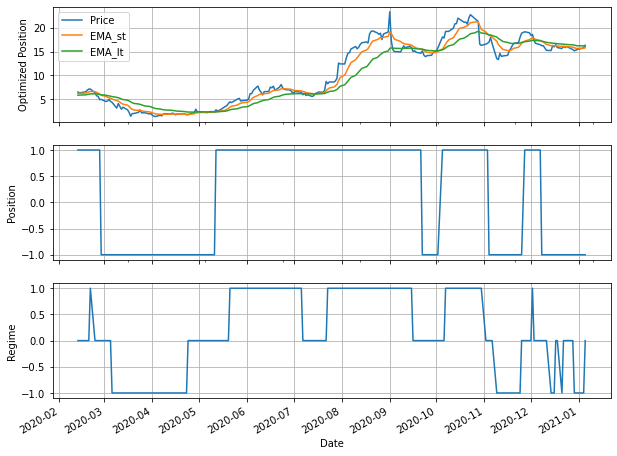

In [8]:
# Plot position
fig = plt.figure()
    
ax1 = fig.add_subplot(311)
data[['Price','EMA_st','EMA_lt']].plot(ax=ax1,grid=True,figsize=(10,8))
ax1.set_ylabel('Optimized Position')

ax2 = fig.add_subplot(312)
data['Position'].plot(ax=ax2,grid=True,figsize=(10,8), sharex=ax1)
ax2.set_ylabel('Position')

ax3 = fig.add_subplot(313)
data['Regime'].plot(ax=ax3,grid=True,figsize=(10,8), sharex=ax1)
ax3.set_ylabel('Regime')


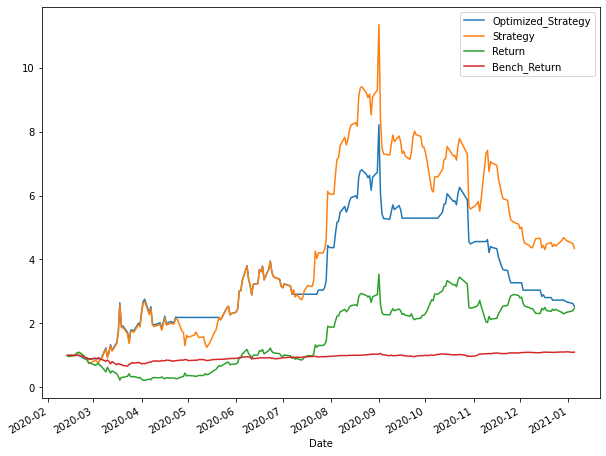

In [9]:
data[['Optimized_Strategy','Strategy','Return','Bench_Return']].cumsum().apply(np.exp).plot(figsize=(10,8))

In [10]:
data[['Optimized_Strategy','Strategy','Return','Bench_Return']].cumsum().apply(np.exp).tail()

,Optimized_Strategy,Strategy,Return,Bench_Return
Date,,,,
2020-12-29,2.727364,4.682233,2.298938,1.102854
2020-12-30,2.698861,4.633300,2.323217,1.104334
2020-12-31,2.672676,4.588345,2.345979,1.111444
2021-01-04,2.620137,4.498150,2.393020,1.095045
2021-01-05,2.531852,4.346584,2.476464,1.100516


## 4. Return & Risk Evaluation

In [11]:
# Annual return
data[['Optimized_Strategy','Strategy','Return','Bench_Return']].mean()*252

Optimized_Strategy    1.040425
Strategy              1.645717
Return                1.011158
Bench_Return          0.106798
dtype: float64

In [12]:
# Annual standard deviation
data[['Optimized_Strategy','Strategy','Return','Bench_Return']].std()*252**0.5

Optimized_Strategy    1.328567
Strategy              1.528496
Return                1.527295
Bench_Return          0.365000
dtype: float64

In [13]:
# Sharpe Ratio
(data[['Optimized_Strategy','Strategy','Return','Bench_Return']].mean()*252) / (data[['Optimized_Strategy','Strategy','Return','Bench_Return']].std()*252**0.5)

Optimized_Strategy    0.783118
Strategy              1.076691
Return                0.662058
Bench_Return          0.292598
dtype: float64

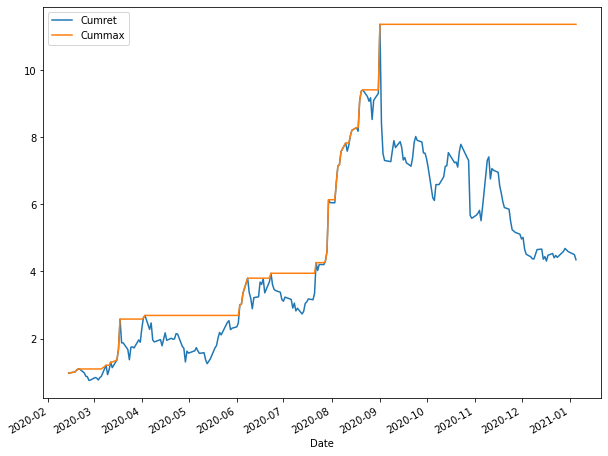

In [14]:
data['Cumret']=data['Strategy'].cumsum().apply(np.exp)
data['Cummax']=data['Cumret'].cummax()
data[['Cumret','Cummax']].plot(figsize=(10,8))

In [15]:
drawdown=data['Cummax']-data['Cumret']
drawdown.max()

7.050911179899704

This strategy works well when HOME price goes down, but will cause loss when HOME price goes up.